In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# DSB Solver

In [2]:


def dsb_solver(J, h=None, n_iter=1000, batch_size=1, dt=1, xi=None, x_init=None):
    """
    Discrete Simulated Bifurcation (DSB) solver for combinatorial optimization problems.
    
    This function implements the Dynamical System of Bounded variables algorithm based on
    classical mechanics principles for combinatorial optimization.
    
    Args:
        J (numpy.array or csr_matrix): Coupling matrix with shape (N x N).
        h (numpy.array, optional): External field with shape (N,). Default: None.
        n_iter (int, optional): Number of iterations. Default: 1000.
        batch_size (int, optional): Number of parallel samples. Default: 1.
        dt (float, optional): Time step size. Default: 1.
        xi (float, optional): Positive constant with dimension of frequency. 
                             If None, calculated automatically. Default: None.
        x_init (numpy.array, optional): Initial spin values with shape (N x batch_size).
                                      If None, initialized randomly. Default: None.
    
    Returns:
        tuple: (final_x, energy, cut_value)
            - final_x: Final spin configuration with shape (N x batch_size)
            - energy: Final energy values with shape (batch_size,)
            - cut_value: Final cut values with shape (batch_size,)
    """
    # Convert J to CSR format if not already
    J = csr_matrix(J)
    N = J.shape[0]
    
    # Handle h properly
    if h is not None and len(h.shape) < 2:
        h = h[:, np.newaxis]
    
    # Initialize xi if not provided
    if xi is None:
        xi = 0.5 * np.sqrt(N - 1) / np.sqrt(csr_matrix.power(J, 2).sum())
    
    # Initialize x
    if x_init is None:
        x = 0.02 * (np.random.rand(N, batch_size) - 0.5)
    else:
        x = x_init
        if x.shape[0] != N:
            raise ValueError(f"The size of x {x.shape[0]} is not equal to the number of spins {N}")
    
    # Initialize y (momentum)
    y = 0.02 * (np.random.rand(N, batch_size) - 0.5)
    
    # Setup parameters
    delta = 1  # positive detuning frequency
    p = np.linspace(0, 1, n_iter)  # pumping amplitude
    
    # Dynamical evolution using modified explicit symplectic Euler method
    for i in range(n_iter):
        if h is None:
            y += (-(delta - p[i]) * x + xi * J.dot(np.sign(x))) * dt
        else:
            y += (-(delta - p[i]) * x + xi * (J.dot(np.sign(x)) + h)) * dt
            
        x += dt * y * delta
        
        # Apply boundary conditions
        cond = np.abs(x) > 1
        x = np.where(cond, np.sign(x), x)
        y = np.where(cond, np.zeros_like(y), y)
    
    # Calculate final energy
    sign_x = np.sign(x)
    if h is None:
        energy = -0.5 * np.sum(J.dot(sign_x) * sign_x, axis=0)
    else:
        energy = -0.5 * np.sum(J.dot(sign_x) * sign_x, axis=0) - h.T.dot(sign_x).flatten()
    
    # Calculate cut value
    cut_value = 0.25 * np.sum(J.dot(sign_x) * sign_x, axis=0) - 0.25 * J.sum()
    
    return sign_x, energy, cut_value

# Solving

Best solution found: [ 1. -1.  1. -1.  1. -1.  1.  1.]
Corresponding energy: -10.0
Max cut value: 14
Total graph weight: 18
Theoretical max possible cut: 9.0


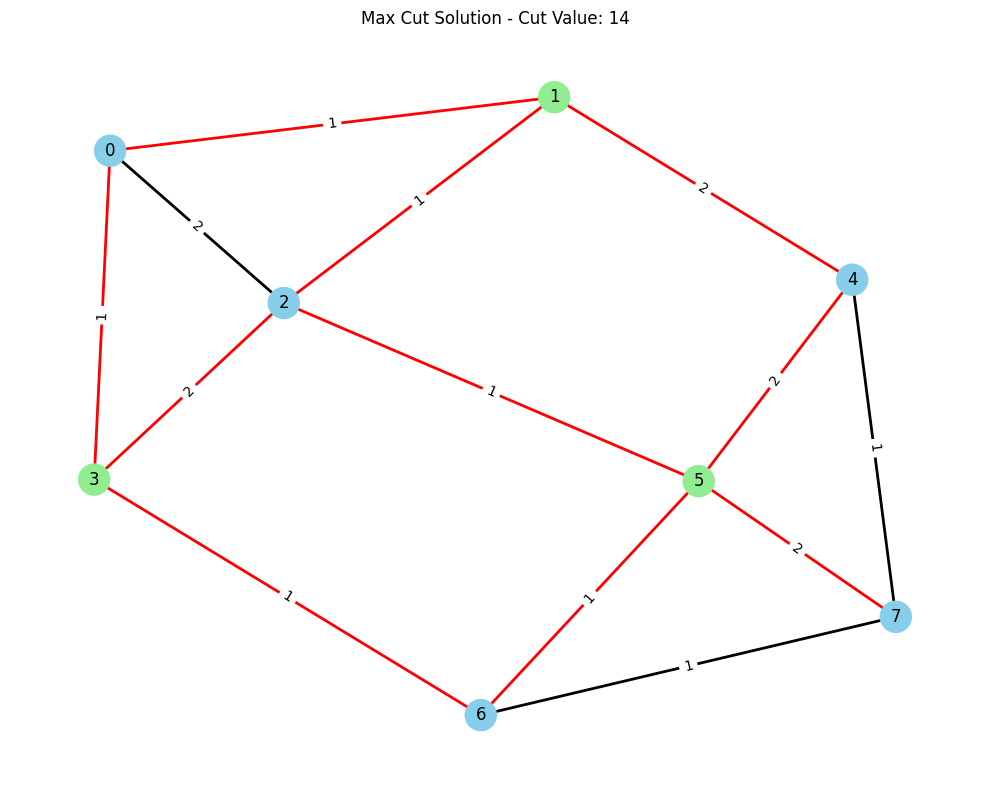

In [3]:


# Import the DSB solver function (assuming it's defined elsewhere)

# Create a simple graph for demonstration
def create_example_graph():
    # Create a simple graph with 8 nodes
    G = nx.Graph()
    
    # Add edges with weights
    edges = [
        (0, 1, 1), (0, 2, 2), (0, 3, 1),
        (1, 2, 1), (1, 4, 2),
        (2, 3, 2), (2, 5, 1),
        (3, 6, 1),
        (4, 5, 2), (4, 7, 1),
        (5, 6, 1), (5, 7, 2),
        (6, 7, 1)
    ]
    
    G.add_weighted_edges_from(edges)
    return G

# Convert graph to QUBO formulation for max cut
def graph_to_maxcut_qubo(G):
    # Number of nodes
    n = G.number_of_nodes()
    
    # Initialize coupling matrix J
    J = np.zeros((n, n))
    
    # Fill in J based on edge weights
    for i, j, weight in G.edges.data('weight'):
        J[i, j] = weight
        J[j, i] = weight
    
    # Convert to sparse matrix for efficiency
    J_sparse = csr_matrix(J)
    
    return J_sparse

# Visualize the graph and the cut
def visualize_maxcut(G, cut_assignment):
    # Create two sets of nodes based on cut assignment
    set_a = [i for i, val in enumerate(cut_assignment) if val > 0]
    set_b = [i for i, val in enumerate(cut_assignment) if val < 0]
    
    # Determine edge colors: red for cut edges, black for others
    edge_colors = []
    cut_value = 0
    
    for u, v, data in G.edges(data=True):
        if (u in set_a and v in set_b) or (u in set_b and v in set_a):
            edge_colors.append('red')
            cut_value += data['weight']
        else:
            edge_colors.append('black')
    
    # Node colors
    node_colors = ['skyblue' if node in set_a else 'lightgreen' for node in G.nodes()]
    
    # Draw the graph
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 8))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
    
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    plt.title(f"Max Cut Solution - Cut Value: {cut_value}")
    plt.axis('off')
    plt.tight_layout()
    
    return cut_value

# Main function to solve max cut problem
def solve_maxcut():
    # Create example graph
    G = create_example_graph()
    
    # Convert to QUBO formulation
    J = graph_to_maxcut_qubo(G)
    
    # For max cut, we negate J because we want to maximize the cut,
    # which is equivalent to minimizing -J
    J_neg = -J
    
    # Solve using DSB
    n_samples = 5  # Run multiple samples to get the best result
    results, energies, cut_values = dsb_solver(
        J=J_neg,
        n_iter=1000,
        batch_size=n_samples,
        dt=1
    )
    
    # Find the best solution (minimum energy = maximum cut)
    best_idx = np.argmin(energies)
    best_solution = results[:, best_idx]
    
    print(f"Best solution found: {best_solution}")
    print(f"Corresponding energy: {energies[best_idx]}")
    
    # Visualize the solution
    cut_value = visualize_maxcut(G, best_solution)
    print(f"Max cut value: {cut_value}")
    
    # Calculate theoretical upper bound for comparison
    total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))
    print(f"Total graph weight: {total_weight}")
    print(f"Theoretical max possible cut: {total_weight/2}")  # This is just an approximation
    
    return G, best_solution, cut_value

# Run the example
if __name__ == "__main__":
    G, solution, cut_value = solve_maxcut()
    plt.show()

